In [1]:
# standard python utilities
import os
from os.path import basename
import sys
from importlib import reload
import glob
import pandas as pd
import numpy as np
import calendar
import time

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from matplotlib.ticker import MaxNLocator

import flopy
import flopy.utils.binaryfile as bf


In [2]:
doc_dir = os.getcwd()
while os.path.basename(doc_dir) != 'Documents':
    doc_dir = os.path.dirname(doc_dir)
    
git_dir = os.getcwd()
while os.path.basename(git_dir) != 'GitHub':
    git_dir = os.path.dirname(git_dir)
usr_dir = os.getcwd()
while os.path.basename(usr_dir) != 'Users':
    temp = os.path.basename(usr_dir)
    usr_dir = os.path.dirname(usr_dir)
usr_dir += '/'+temp

py_dir = git_dir +'/CosumnesRiverRecharge/python_utilities/'
## Set up directory referencing
# Package data
gwfm_dir = usr_dir+'/Box/research_cosumnes/GWFlowModel/'
gwfm_dir
bas_dir = gwfm_dir + 'BAS6/'
proj_dir = gwfm_dir+'Levee_setback/'
plt_dir = proj_dir+'figures/'


In [5]:
# run_dir = 'C://WRDAPP/GWFlowModel'
run_dir = 'F://WRDAPP/GWFlowModel'
loadpth = run_dir +'/Cosumnes/Regional/'

model_nam = 'historical_simple_geology'


model_ws = loadpth+model_nam


In [31]:

m = flopy.modflow.Modflow.load('MF.nam', model_ws= model_ws, 
                                exe_name='mf-owhm', version='mfnwt')

# m_ss = flopy.modflow.Modflow.load('MF.nam', model_ws= loadpth+'historical_SS', 
#                                 exe_name='mf2005', version='mfnwt')

In [32]:
if 'LPF' in m.get_package_list():
    gel_nam = 'LPF'
else:
    gel_nam = 'UPW'
gel = m.__getattr__(gel_nam)

In [8]:
sfr_dir = gwfm_dir+'/SFR_data/'
grid_sfr = gpd.read_file(sfr_dir+'/final_grid_sfr/grid_sfr.shp')
grid_sfr['Kz'] = m.sfr.reach_data.strhc1
m_domain = gpd.read_file(gwfm_dir+'/DIS_data/NewModelDomain/GWModelDomain_52_9deg_UTM10N_WGS84.shp')
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
grid_p['easting'] = grid_p.geometry.centroid.x
grid_p['northing'] = grid_p.geometry.centroid.y

lak_grid_clip = gpd.read_file(proj_dir+'lak_grid_clip/lak_grid_clip.shp')


In [9]:
map_fxn_dir = doc_dir+'/GitHub/CosumnesRiverRecharge/python_utilities'
if map_fxn_dir not in sys.path:
    sys.path.append(map_fxn_dir)
# sys.path
import map_obs_plt as mop
from map_obs_plt import plt_bc_hk, plot_head_simple, plot_dtw_simple
from map_cln import gdf_2_lims

from importlib import reload
# importlib.reload
reload(mop)

<module 'map_obs_plt' from 'C:\\Users\\ajcalder\\Documents/GitHub/CosumnesRiverRecharge/python_utilities\\map_obs_plt.py'>

# Head plots and contours

In [10]:
hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
spd_stp = hdobj.get_kstpkper()
times = hdobj.get_times()
cbc = model_ws+'/MF.cbc'

strt_date = pd.to_datetime(m.dis.start_datetime)
dates = strt_date+(np.asarray(times)-1).astype('timedelta64[D]')

dt_ref = pd.DataFrame(dates, columns=['dt'])
dt_ref['kstpkper'] = spd_stp


In [11]:
dt_ref.shape, m.rch.rech.array.shape, m.dis.nper, len(times)

((1462, 2), (1462, 1, 100, 230), 1462, 1462)

In [12]:
rech = m.rch.rech.array[:,0,:,:]
rech_avg = pd.Series(rech.mean(axis=(1,2)))[1:]
# rech_avg.index=dt_ref.dt[:-1]



In [13]:
storativity = np.array(pd.read_csv(model_ws+'/input_data/storativity.tsv', delimiter=' ',header=None))
storativity = np.reshape(storativity, (m.dis.nlay, m.dis.nrow, m.dis.ncol))


In [15]:
# hdobj_ss = flopy.utils.HeadFile(loadpth+'historical_SS/MF.hds')
# hdobj_ss = flopy.utils.HeadFile(loadpth+'historical_streamflow/MF.hds')
# temp = hdobj_ss.get_data((0,0))
# plt.imshow(temp[0,:,:])
# plt.colorbar()

In [ ]:
# this doesn't seem to have helped much
# dir_current = 'historical_streamflow'
# dir_2010 = 'historical_SS'
# head_current = np.zeros(m.dis.botm.shape)
# head_2010 = np.zeros(m.dis.botm.shape)

# for k in np.arange(0,m.dis.nlay):
#     head_current[k,:,:] = np.loadtxt(bas_dir+'steadystate_heads/'+dir_current+'/layer'+str(k)+'.tsv',delimiter='\t')
#     head_2010[k,:,:] = np.loadtxt(bas_dir+'steadystate_heads/'+dir_2010+'/layer'+str(k)+'.tsv',delimiter='\t')

In [ ]:
# plt.imshow((head_current-head_2010)[0,:,:], vmin=-100)
# plt.colorbar()

In [ ]:
# save steady state head to try to improve ss run time
# head_ss = hdobj_ss.get_data((0,0))
# os.makedirs(bas_dir+'steadystate_heads/'+basename(model_ws), exist_ok=True)
# for k in np.arange(0,head_ss.shape[0]):
#     np.savetxt(bas_dir+'steadystate_heads/'+basename(model_ws)+'/layer'+str(k)+'.tsv', head_ss[k,:,:],delimiter='\t')

# Sim vs Obs Head


In [16]:
hobout = pd.read_csv(model_ws+'/MF.hob.out',delimiter=r'\s+', header = 0,names = ['sim_val','WSE','obs_nam'],
                     dtype = {'sim_val':float,'obs_val':float,'obs_nam':object},
                    na_values=[-9999.])
# if only one obs exists correct naming convention
one_obs = ~hobout.obs_nam.str.contains('.0')
hobout.loc[one_obs,'obs_nam'] = hobout.loc[one_obs,'obs_nam']+'.'+str(1).zfill(5)

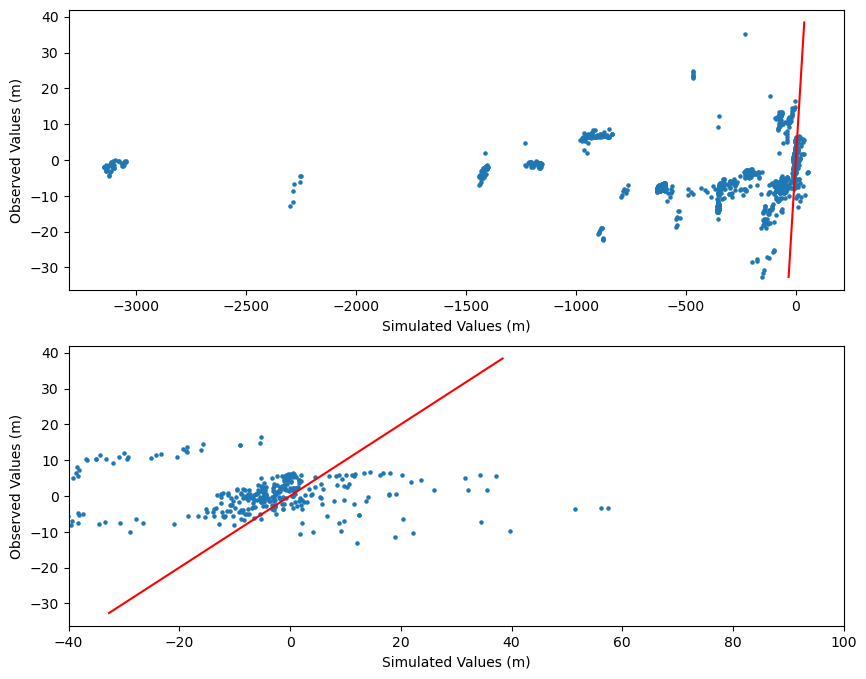

In [17]:
fig, ax = plt.subplots(2,1,figsize=(10,8))

# get boundary values for plotting a 1:1
hobmax = hobout.loc[:,['sim_val','WSE']].max().min()
hobmin = hobout.loc[:,['sim_val','WSE']].min().max()

# plot observed vs simulated values
hobout.plot.scatter(x='sim_val',y='WSE',marker='.',ax=ax[0])
ax[0].plot([hobmin,hobmax],[hobmin,hobmax],'red')
ax[0].set_ylabel('Observed Values (m)')
ax[0].set_xlabel('Simulated Values (m)')

hobout.plot.scatter(x='sim_val',y='WSE',marker='.',ax=ax[1])
ax[1].set_xlim(-40,100)

# plot 1:1 line
ax[1].plot([hobmin,hobmax],[hobmin,hobmax],'red')

plt.ylabel('Observed Values (m)')
plt.xlabel('Simulated Values (m)')

fig_nam = plt_dir+'GSP_WaterBudget/sim_vs_obs_heads'

# plt.savefig(fig_nam+'.png',dpi=600,bbox_inches='tight')
# plt.savefig(fig_nam+'.svg',dpi=600,bbox_inches='tight')

In [18]:
def mak_hob_gpd(hobout):
    all_obs = pd.read_csv(model_ws+'/input_data/all_obs_grid_prepared.csv',index_col=0)
    all_obs.index = all_obs.index.rename('MSMT_DATE')
    all_obs = all_obs.reset_index()
    # join more indepth obs data to output simulated heads
    obs_data = hobout.join(all_obs.set_index('obs_nam'),on=['obs_nam'])
    obs_data = obs_data.dropna(subset=['node'])
    obs_data.loc[:,['row','column','node']] = obs_data.loc[:,['row','column','node']].astype(int)

    # obs_data.index = obs_data.index
    obs_grid = obs_data.join(grid_p.set_index(['row','column']).loc[:,['easting','northing']], 
                             on=['row','column'])
    # # convert back to geospatial
    hob_gpd = gpd.GeoDataFrame(obs_grid, geometry = gpd.points_from_xy(obs_grid.easting, obs_grid.northing))
    hob_gpd['error'] = hob_gpd.WSE - hob_gpd.sim_val
    hob_gpd['abs_error'] = hob_gpd.error.abs()
    
    if 'MSMT_DATE' in hob_gpd.columns:
        hob_gpd = hob_gpd.set_index('MSMT_DATE')
        hob_gpd.index = pd.to_datetime(hob_gpd.index)    
        #     groupby values by season
        hob_gpd.loc[(hob_gpd.index.month > 2)&(hob_gpd.index.month < 6),'season'] = 'spring'
        hob_gpd.loc[(hob_gpd.index.month > 8)&(hob_gpd.index.month < 12),'season'] = 'fall'
    
    return(hob_gpd)
    # set date
    


In [19]:
hob_gpd = mak_hob_gpd(hobout)

hob_seasonal = hob_gpd.groupby(['node','season']).mean()
hob_seasonal = gpd.GeoDataFrame(hob_seasonal, geometry = gpd.points_from_xy(hob_seasonal.easting, hob_seasonal.northing))
hob_seasonal = hob_seasonal.reset_index()
    


C:\Users\ajcalder\AppData\Local\Temp\ipykernel_51892\1036705254.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  obs_data.loc[:,['row','column','node']] = obs_data.loc[:,['row','column','node']].astype(int)
C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)
C:\Users\ajcalder\AppData\Local\Temp\ipykernel_51892\3103077545.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which

In [20]:
hob_gpd['Statistic'] = 0.01
hob_gpd['StatFlag'] = 'SD'
# locations with significant difference between RPE GSE and the DEM should have additional uncertainty included
hob_gpd['Statistic'] += np.round(np.abs(hob_gpd.dem_wlm_gse),4)
hob_gpd['Weight'] = 1/(hob_gpd.Statistic**2)

soswr = (np.sum(np.abs(hob_gpd.sim_val-hob_gpd.WSE)*hob_gpd.Weight))
print('Sum of absolute difference of OBS and SIM: %.2e' %soswr)

Sum of absolute difference of OBS and SIM: 4.92e+07


In [21]:
# print('Upper Cosumnes - deep DTW expected')

# hob_interest = hob_gpd.loc[hob_gpd.node.isin([14644, 15343, 16963])]
# print('Simulated DTW (ft): ',(hob_interest.dem_elev - hob_interest.sim_val).values/0.3048)
# print('Observed DTW (ft): ',(hob_interest.dem_elev - hob_interest.WSE).values/0.3048)

# # hob_interest
# print('Lower Cosumnes - shallow DTW expected')
# hob_interest = hob_gpd.loc[hob_gpd.node.isin([9448, 6458, 17487])]
# print('Simulated DTW (ft): ',(hob_interest.dem_elev - hob_interest.sim_val).values/0.3048)
# print('Observed DTW (ft): ',(hob_interest.dem_elev - hob_interest.WSE).values/0.3048)

# hob_interest

The error is slightly smaller than presented because I used the raw GWE which is based on the surveyed land surface elevation instead of the adjusted water surface elevation based on the model top elevation. Additionally these three wells are in a part of the basin with grassland/pasture that I was not simulating for pumping because it was such a large portion of the domain and it is difficult to know whether it is irrigated or not. It may need to be adjusted to allow pumping on pasture when it is near a domestic or agricultural well (say a radius of 1000 ft or 300 m). South of the Cosumnes water levels tend to be even lower than on the north side where perhaps Deer Creek provides more recharge.

In [22]:
# convert pumping to array
pump = np.zeros((m.dis.nper,m.dis.nrow,m.dis.ncol))
for n in np.arange(0,m.dis.nper):
    wel_n = m.wel.stress_period_data[n]
    pump[n, wel_n.i, wel_n.j] += wel_n.flux*-1
pump_rate = pump/(m.dis.delr[0]*m.dis.delc[0])

In [23]:
# import contextily as ctx

def background_plt(ax, arr):
    ''' Plot Array data over background map data'''
    mapview = flopy.plot.PlotMapView(model=m,ax=ax)

    csa = mapview.plot_array(arr, ax=ax, alpha = 0.6) #norm=mpl.colors.LogNorm(),
    cb = plt.colorbar(csa, shrink=0.3,ax=ax)
    
    # hob_gpd[hob_gpd.node.isin(nodes2chk)].plot('node', ax=ax, legend=True)
    hob_gpd[hob_gpd.node.isin(nodes2chk)].plot('SITE_CODE', ax=ax, legend=False, legend_kwds={'loc':(1.2,0.4)})

    grid_sfr.plot('Kz', ax=ax,legend=False, 
                  norm=mpl.colors.LogNorm(vmin=grid_sfr.Kz.min(), vmax=grid_sfr.Kz.max()),
                  legend_kwds={'shrink':0.8})
#     ctx.add_basemap(ax=ax, crs='epsg:32610', alpha = 0.6,
#                     source = ctx.providers.Esri.WorldImagery, attribution=False)
    return(mapview)

# nodes2chk = [11084, 10383,10161,9290,8437,6564,14626,15314,6085,13407,10384,16614,20285]
# nodes2chk = [11218,8437,16963,9580,5056,15343,14626,15314] # nodes with obs avg well below simulated
# # nodes2chk = [9290,22825, 11218] # nodes without overly large 2017 fluctuations

# fig,ax0=plt.subplots(1,2, figsize=(10,10))

# ax = ax0[0]
# mapview = background_plt(ax=ax0[0], arr = (hdobj.get_data((0,365)).mean(axis=0) - h_ss))

# ax = ax0[1]
# mapview = background_plt(ax=ax0[1], arr = m.rch.rech.array[1:365,0,:,:].mean(axis=0))


# fig.tight_layout()

C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\plotting.py:71: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\plotting.py:973: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mc_version < LooseVersion("2.2.0"):
C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\plotting.py:71: DeprecationWarni

<AxesSubplot: >

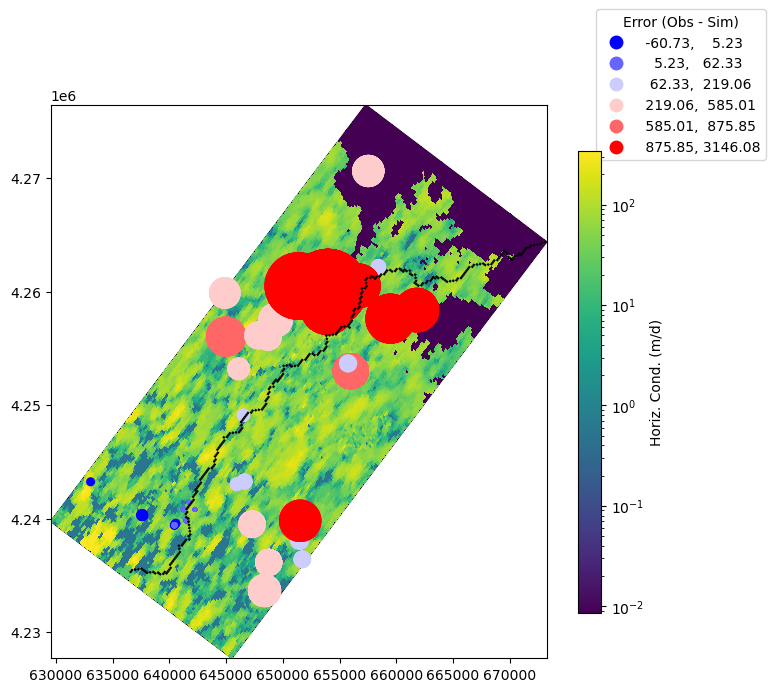

In [24]:
fig,ax=plt.subplots(figsize=(8, 8))
# m = m_ss
m_domain.plot(ax=ax,color='None')
mapview = flopy.plot.PlotMapView(model=m,ax=ax)
a = gel.hk.array

csa = mapview.plot_array(a[0,:,:], norm=mpl.colors.LogNorm())
cb = plt.colorbar(csa, shrink=0.75,ax=ax)
cb.set_label('Horiz. Cond. (m/d)')

# hob_gpd.plot('error',scheme='EqualInterval', k= 6, ax=ax,legend=True,cmap='magma')
hob_gpd.plot('error',markersize='abs_error',scheme='Quantiles', k = 6, ax=ax,
                  legend=True,cmap='bwr',legend_kwds={'loc':(1.1,0.9),'title':'Error (Obs - Sim)'})
# hob_gpd.apply(lambda x: ax.annotate(str(x.node), xy=x.geometry.centroid.coords[0], ha='right'),axis=1);
# hob_gpd.apply(lambda x: ax.annotate(str(x.node), xy=list(x.geometry.coords)[0], ha='right'),axis=1);

grid_sfr.plot(ax=ax,color='black')
# ax.legend(loc=(1,0.5))

In [33]:
nodes2chk = [202825, 12944, 6085, 14626, 6564, 9580, 8437, 21451, 10384, 13407, 946] # not enough fluctuations

# nodes2chk = [22825, 12944, 6085, 14626, 6564, 9580, 8437] # not enough fluctuations
# nodes2chk = [10165, 9290, 10161, 11084, 11078, 10383] # fluctuate well, near river, shallow (6 from CRP)
chk = hob_gpd[hob_gpd.node.isin(nodes2chk)]
chk.layer.unique()
# chk.dem_elev.unique()

# chk.SITE_CODE.unique()

array([1, 2], dtype=int64)

In [35]:
ss_chk = gel.ss.array[chk.layer.astype(int), chk.row.astype(int), chk.column.astype(int)]
hk_chk = gel.hk.array[chk.layer.astype(int), chk.row.astype(int), chk.column.astype(int)]
# hk_chk

In [59]:
# hob_gpd[hob_gpd.node.isin(nodes2chk)].columns
# hob_gpd[hob_gpd.node.isin(nodes2chk)].groupby('SITE_CODE').mean()

In [58]:
# fig,ax = plt.subplots(2,1,figsize=(8,8))
# # nodes2chk = [10165, 9290, 10161, 11084, 11078, 10383] # fluctuate well, near river, shallow (6 from CRP)
# nodes2chk = [4579, 5056] # fluctuate well, near river, shallow (6 from CRP)

# hob_gpd[hob_gpd.node.isin(nodes2chk)].reset_index().plot(x='MSMT_DATE',y='WSE',kind='scatter', ax=ax[0], 
#                                                          marker='x', color='red')
# hob_gpd[hob_gpd.node.isin(nodes2chk)].reset_index().plot(x='MSMT_DATE',y='sim_val',kind='scatter', ax=ax[0], marker='o')

# rech_avg.resample('M').sum().plot(ax=ax[1], sharex=ax[0])


In [38]:
# hdobj = flopy.utils.HeadFile(model_ws+'/MF.hds')
# spd_stp = hdobj.get_kstpkper()
# times = hdobj.get_times()
# cbc = model_ws+'/MF.cbc'

hobout = pd.read_csv(model_ws+'/MF.hob.out',delimiter=r'\s+', header = 0,names = ['sim_val','WSE','obs_nam'],
                     dtype = {'sim_val':float,'obs_val':float,'obs_nam':object},
                    na_values=[-9999.])
# if only one obs exists correct naming convention
one_obs = ~hobout.obs_nam.str.contains('.0')
hobout.loc[one_obs,'obs_nam'] = hobout.loc[one_obs,'obs_nam']+'.'+str(1).zfill(5)

hob_gpd = mak_hob_gpd(hobout)

# find sites with long time series of OBS
hobs_long = (hob_gpd.groupby('SITE_CODE').count()>=int(m.dis.nper/365)*2)
hobs_long = hobs_long.index[hobs_long.WSE].values
# hobs_long.shape
# get layer, row, column for extracting time series head data
hob_kij = hob_gpd.drop_duplicates('node')[['node','layer','row','column']]
hob_kij['kij'] = list(hob_kij[['layer','row','column']].astype(int).itertuples(index=False,name=None)) #hob_ts


C:\Users\ajcalder\AppData\Local\Temp\ipykernel_51892\1036705254.py:8: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  obs_data.loc[:,['row','column','node']] = obs_data.loc[:,['row','column','node']].astype(int)
C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


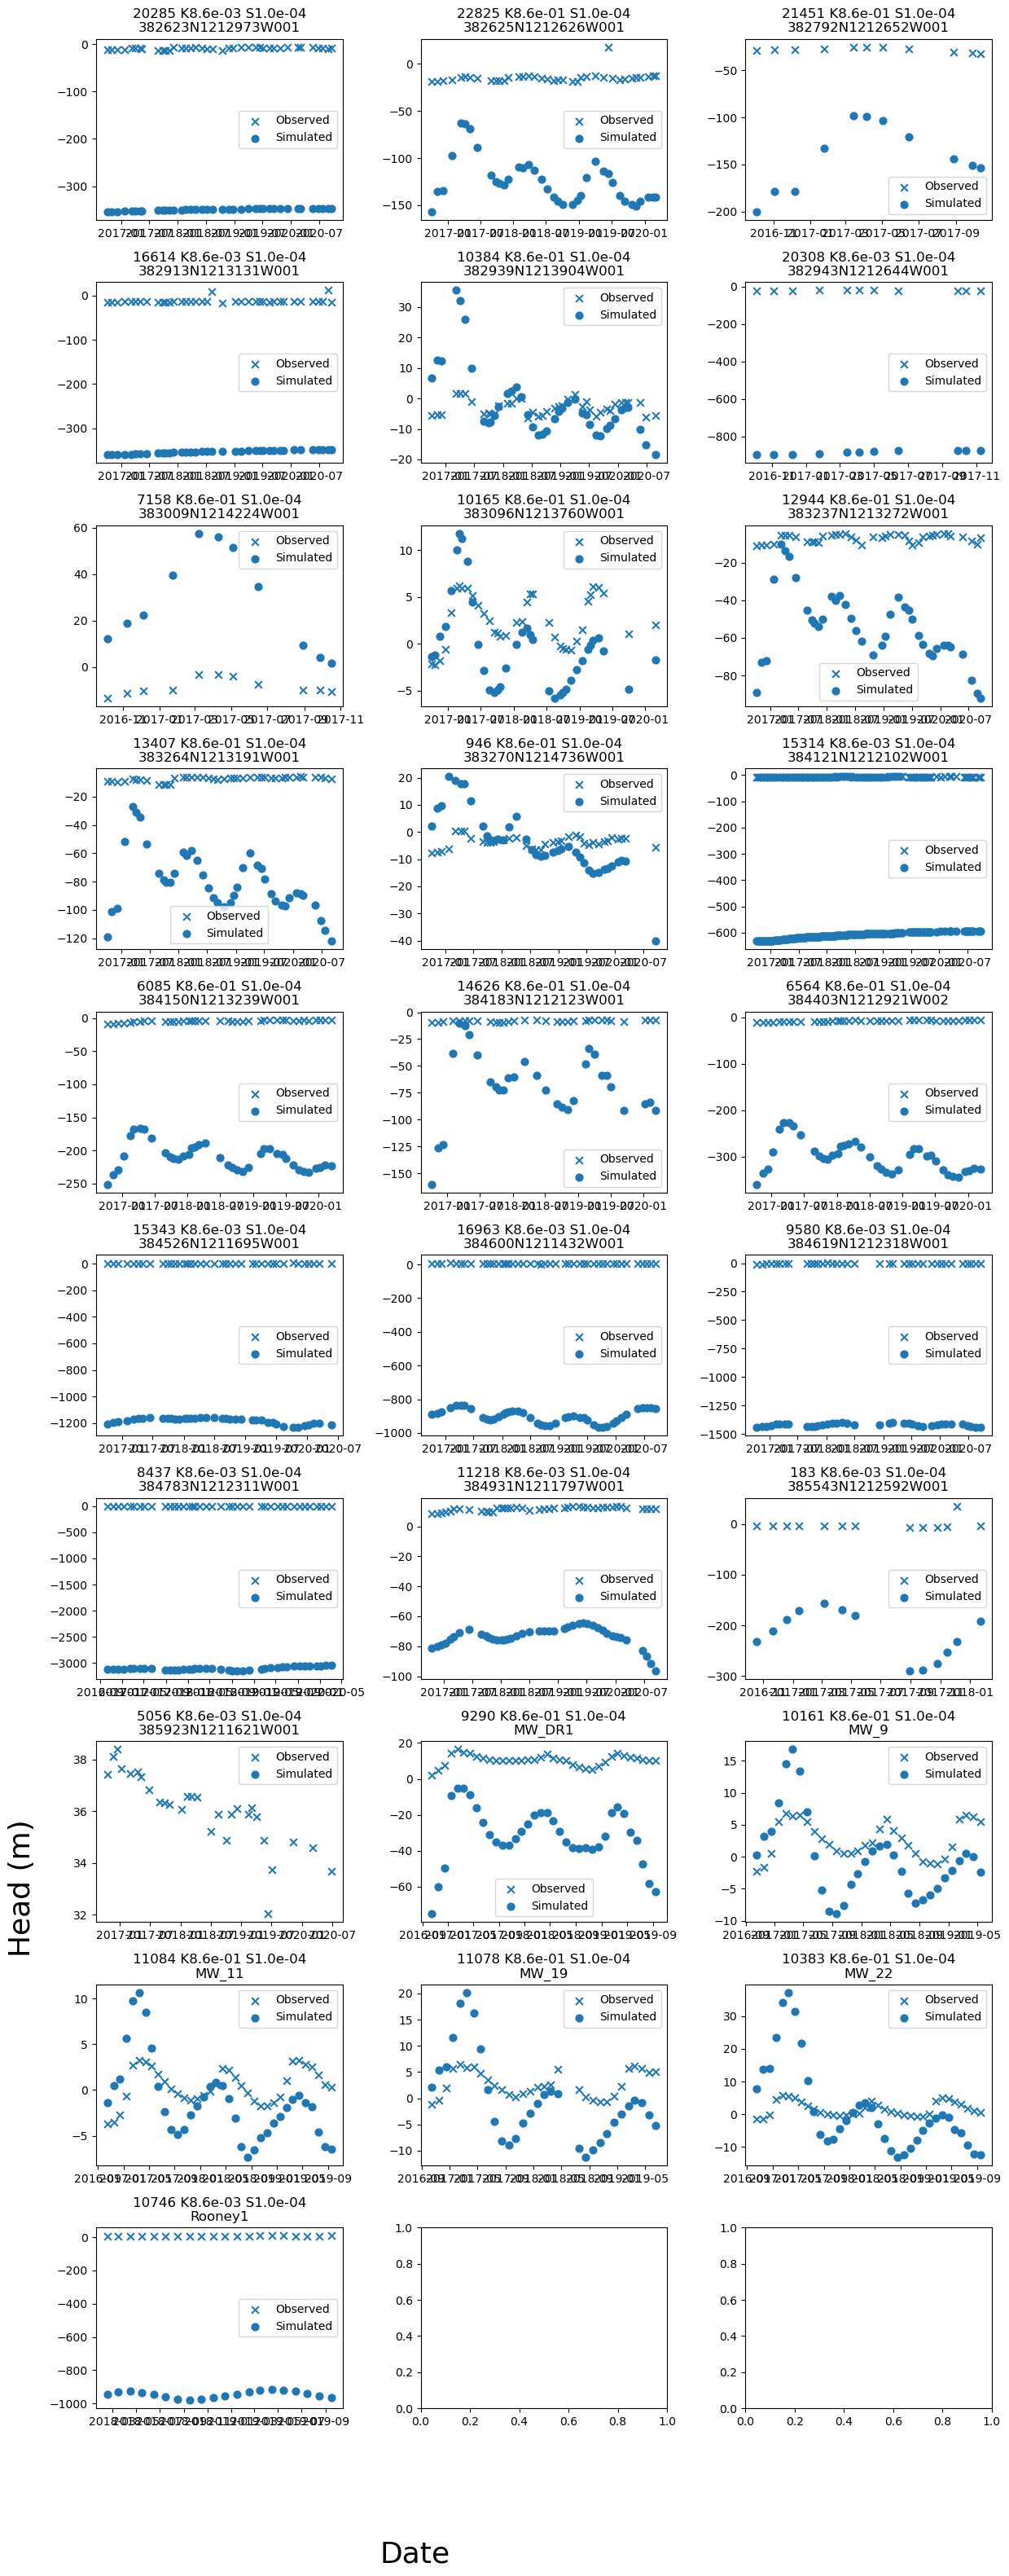

In [39]:
# voi = [4579, 11218, 15343,
#        14644, 14626, 11845,
#        12511, 8594,10884,
#        14789, 16614, 22825, 
#       11078, 14972, 19794]
voi = hob_gpd[hob_gpd.SITE_CODE.isin(hobs_long)].node.unique()
# voi = 22825
# def obs_sim_node(voi):
ny = 3
nx = int(np.ceil(len(voi)/ny))
fig,ax=plt.subplots(nx,ny,figsize=(12,3*nx))
for i,voi_n in enumerate(voi):
    ax_n = ax[int(i / ny), i % ny] if (nx > 1) else ax[i]
    hob_n = hob_gpd[hob_gpd.node==voi_n]
    hob_n.reset_index().plot(x='MSMT_DATE',y='WSE',kind='scatter', ax=ax_n,
                                                  marker='x', s=40, label = 'Observed')
    hob_n.reset_index().plot(x='MSMT_DATE',y='sim_val',kind='scatter', ax=ax_n, 
                                                  marker='o', s=40,label='Simulated')
    # add time series of simulated data to see true peaks
#     ts_i = pd.DataFrame(hdobj.get_ts(hob_kij[hob_kij.node==voi_n].kij.values[0]),columns=['spd','sim_val']) 
#     ts_i['dt'] = dt_ref.dt
#     ts_i.plot(x='dt',y='sim_val', ax=ax_n, legend=False)

    ax_n.set_xlabel('')
    ax_n.set_ylabel('')
    S_n = format(gel.ss.array[hob_n.layer.iloc[0],hob_n.row.iloc[0],hob_n.column.iloc[0]],'.1e')
    K_n = format(gel.hk.array[hob_n.layer.iloc[0],hob_n.row.iloc[0],hob_n.column.iloc[0]], '.1e')

    ax_n.set_title(str(voi_n)+' K'+K_n+' S'+S_n+'\n'+hob_n.SITE_CODE.iloc[0])
ax_n.legend()
fig.text(-0.03, 0.2, 'Head (m)',rotation='vertical',size=26)
fig.text(0.35, -0.05, 'Date',size=26)
fig.tight_layout()

# obs_sim_node(voi)
# hob_gpd[hob_gpd.node==22825].plot(x='MSMT_DATE',y='WSE',kind='scatter')


In [55]:
# ss is relatively consistent, sy is much larger in upper layer
# hk is most likely driving the steep gradients because there is a big contrast between top and deep layers
# now that most of the pumping is in layers with very low conductivity we see steeper gradients
# for k in np.arange(0,m.dis.nlay):
#     plt.imshow(gel.vka.array[k,:,:])
#     plt.colorbar(shrink=0.6)
#     plt.show()

C:\Users\ajcalder\Anaconda3\envs\all\lib\site-packages\flopy\plot\crosssection.py:1504: MatplotlibDeprecationWarning: Passing the match_original parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  patches = PatchCollection(rectcol, match_original, **kwargs)


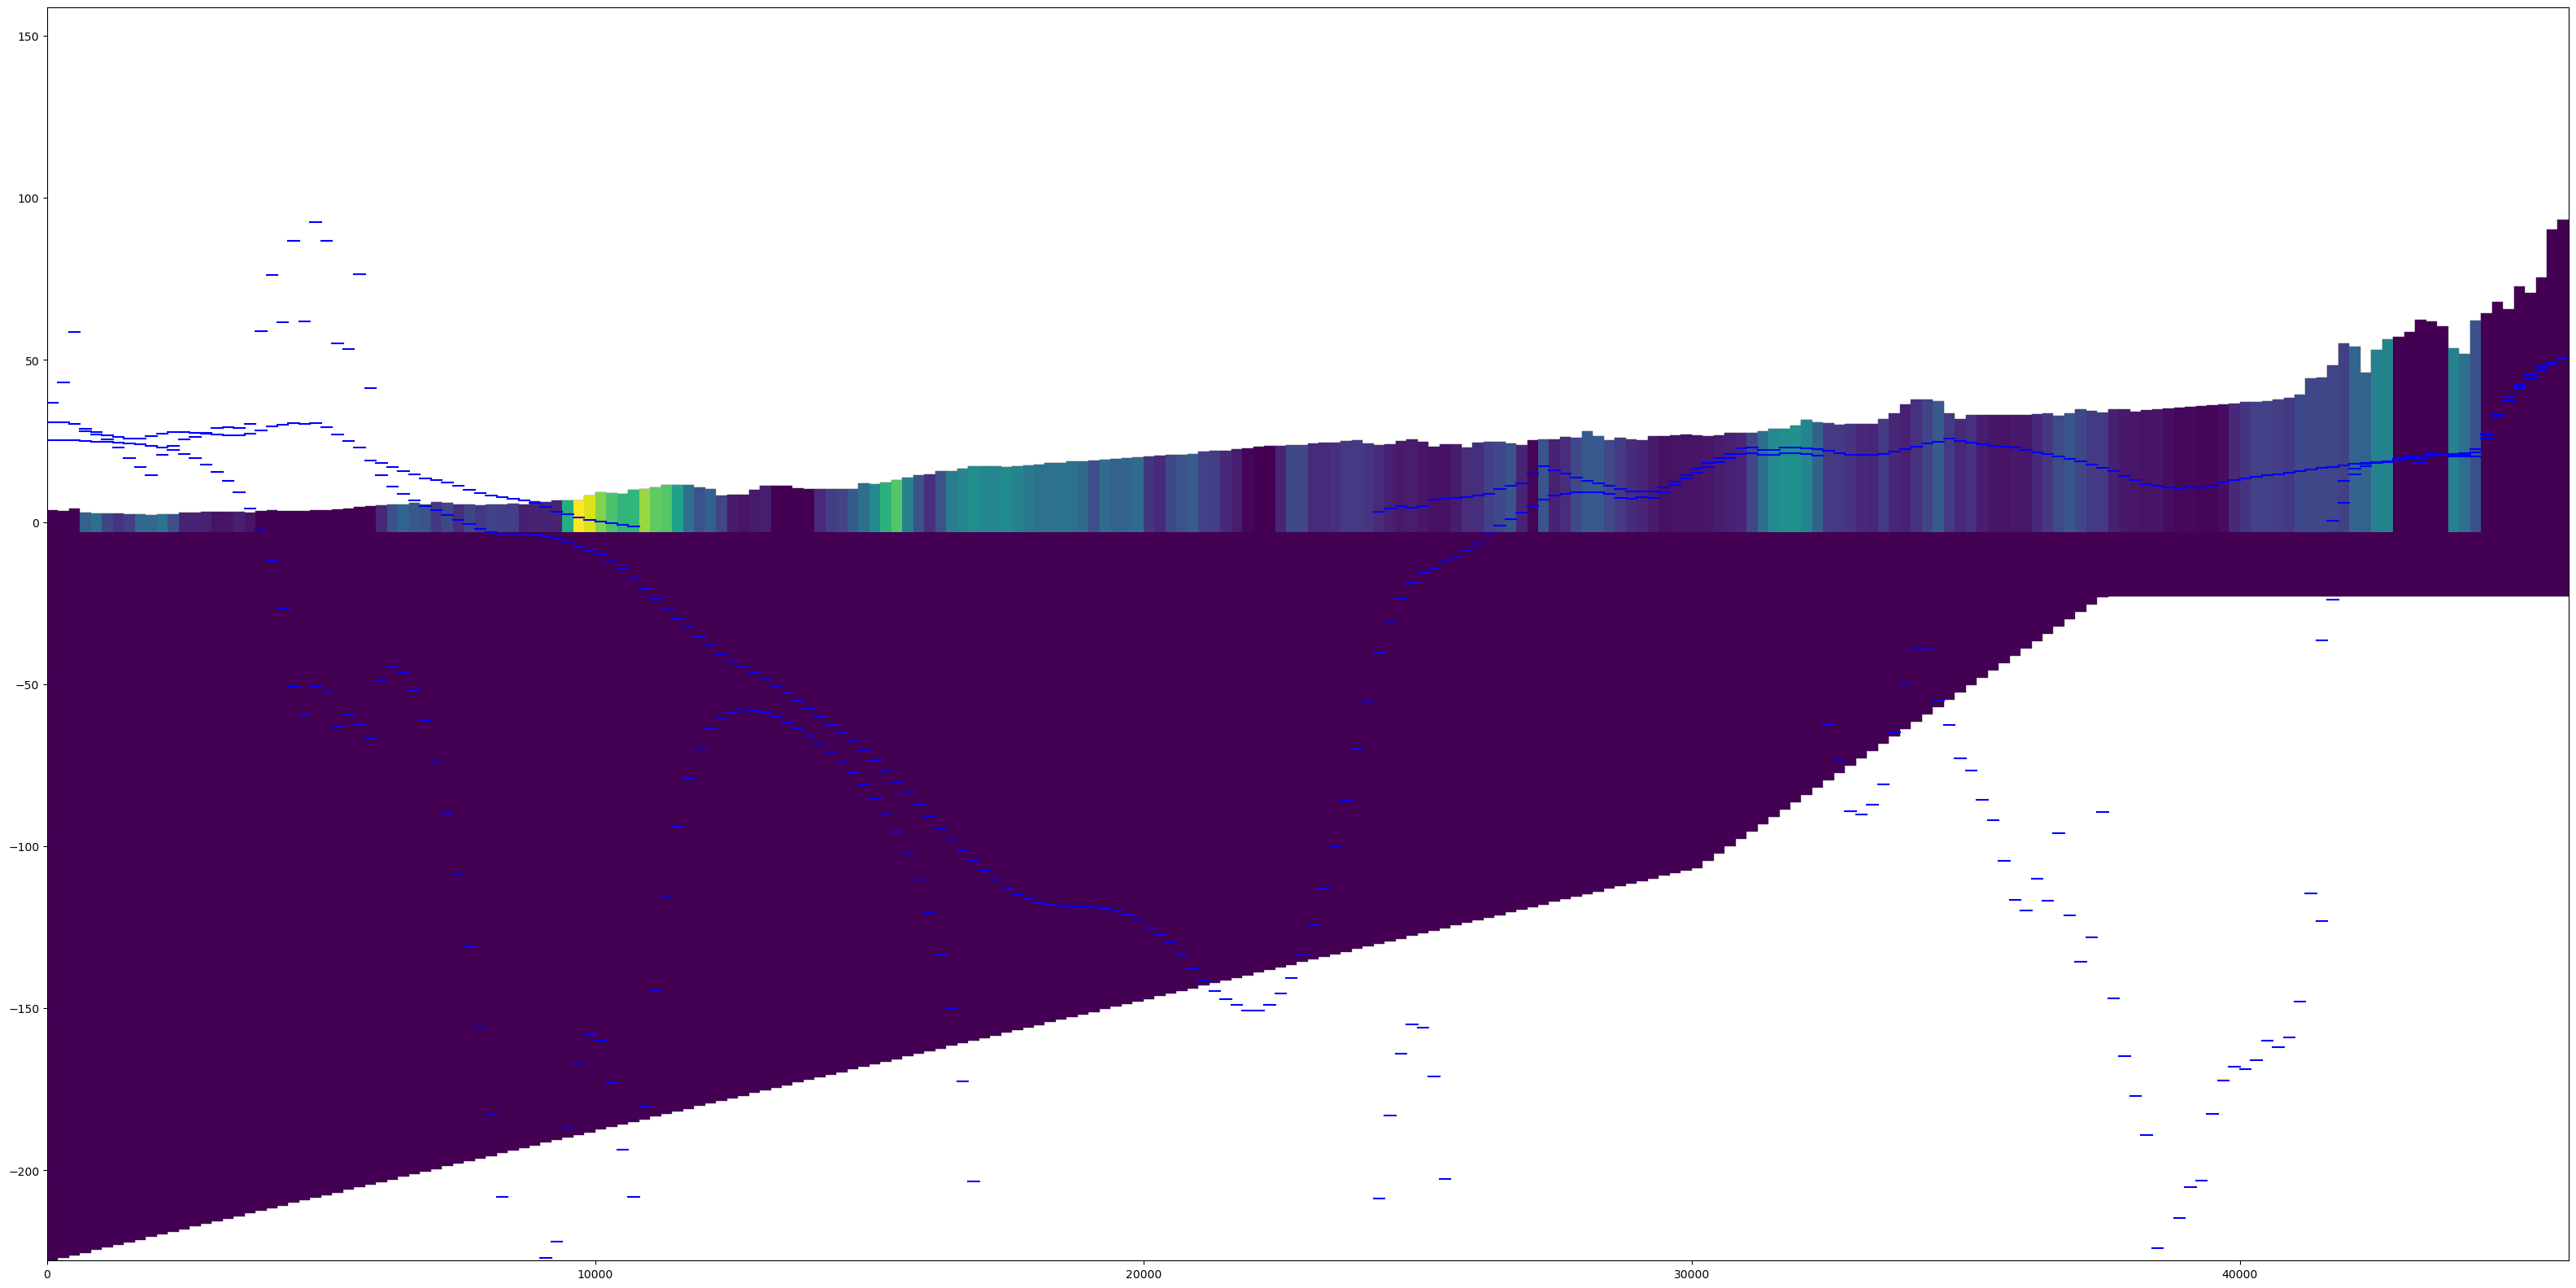

In [40]:
fig = plt.figure(figsize=(40, 20))
ax = fig.add_subplot(1, 1, 1)

head = hdobj.get_data(kstpkper = spd_stp[0]) #spd_stp[0]
head.shape
# head[:,rownum,:].shape

rownum = 50
mcs = flopy.plot.PlotCrossSection(model=m, line={'Row' : rownum})

# colnum = 150
# mcs = flopy.plot.PlotCrossSection(model=m, line={'Column' : colnum})

linecollection = mcs.plot_grid(linewidth = 0.3)
ax.add_collection(linecollection)
# mcs.contour_array(a=head)
mcs.plot_array(a=m.lpf.hk.array)

wt = mcs.plot_surface(a=head[:,:,:])
